# Automatic program Repair (APR)

In [1]:

import sys

import os
sys.path.append(os.path.abspath(os.path.join('..')))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from data_loader.loader import load_buggy_dataset
from bug_detective.detective import process_prompt_dataset

# Add the data_loader module to the path

# Import data loader functions

# Load sample train data
print("Loading sample train data...")

# Load buggy train dataset
buggy_train_df = load_buggy_dataset('train')


Loading sample train data...


In [ ]:

# sample_data = buggy_train_df.sample(n=3, random_state=42)
sample_data = 
print(f"Sample data shape: {sample_data.shape}")
print(f"Sample data columns: {sample_data.columns.tolist()}")


Sample data shape: (3, 16)
Sample data columns: ['after_merge', 'before_merge', 'filename', 'full_file_code_after_merge', 'full_file_code_before_merge', 'function_name', 'url', 'source code and errors', 'full_traceback', 'traceback_type', 'before_merge_without_docstrings', 'after_merge_without_docstrings', 'before_merge_docstrings', 'after_merge_docstrings', 'path_to_snippet_before_merge', 'path_to_snippet_after_merge']


In [3]:
from llm_models.open_router import create_openrouter_model

qwen_model = create_openrouter_model(
    model_name="qwen/qwen-2.5-coder-32b-instruct",
    temperature=0.0,
    max_tokens=1000
)

In [5]:
outputs = await process_prompt_dataset(qwen_model, sample_data)

Processing sample 1/3:   0%|                                             | 0/3 [00:00<?, ?samples/s]

🔄 Initializing OpenRouter client...
📝 Building enhanced prompt...
🚀 Generating code with model: qwen/qwen-2.5-coder-32b-instruct


Processing sample 2/3:  33%|████████████▎                        | 1/3 [00:05<00:10,  5.43s/samples]

🧹 Cleaning and extracting code...
✅ Code generation completed!
🔄 Initializing OpenRouter client...
📝 Building enhanced prompt...
🚀 Generating code with model: qwen/qwen-2.5-coder-32b-instruct


Processing sample 3/3:  67%|████████████████████████▋            | 2/3 [00:16<00:08,  8.47s/samples]

🧹 Cleaning and extracting code...
✅ Code generation completed!
🔄 Initializing OpenRouter client...
📝 Building enhanced prompt...
🚀 Generating code with model: qwen/qwen-2.5-coder-32b-instruct


Processing sample 3/3: 100%|█████████████████████████████████████| 3/3 [00:29<00:00,  9.76s/samples]

🧹 Cleaning and extracting code...
✅ Code generation completed!


In [11]:
sample_data['qwen_output'] = outputs

In [12]:
sample_data.head()

,after_merge,before_merge,filename,full_file_code_after_merge,full_file_code_before_merge,function_name,url,source code and errors,full_traceback,traceback_type,before_merge_without_docstrings,after_merge_without_docstrings,before_merge_docstrings,after_merge_docstrings,path_to_snippet_before_merge,path_to_snippet_after_merge,qwen_output
559729,"def __init__(self,\n callb...","def __init__(self,\n callb...",telegram/ext/handler.py,#!/usr/bin/env python\n#\n# A library that pro...,#!/usr/bin/env python\n#\n# A library that pro...,Handler.__init__,https://github.com/python-telegram-bot/python-...,"[{'piece_type': 'source code', 'piece_content'...",<project_path>/venv/bin/python <project_path>/...,telegram.error.BadRequest,"def __init__(self,\n callb...","def __init__(self,\n callb...",[],[],buggy_snippets_files/55116f59e2e1db46cd75a8a88...,buggy_snippets_files/55116f59e2e1db46cd75a8a88...,"def __init__(self,\n callback,\n ..."
506345,"def drawRightStatus(vd, scr, vs):\n 'Draw r...","def drawRightStatus(vd, scr, vs):\n 'Draw r...",visidata/statusbar.py,import collections\nimport curses\n\nfrom visi...,import collections\nimport curses\n\nfrom visi...,drawRightStatus,https://github.com/saulpw/visidata/issues/577,"[{'piece_type': 'error message', 'piece_conten...","Traceback (most recent call last):\nFile ""/Use...",TypeError,"def drawRightStatus(vd, scr, vs):\n \n r...","def drawRightStatus(vd, scr, vs):\n \n r...",[Draw right side of status bar. Return length...,[Draw right side of status bar. Return length...,buggy_snippets_files/36f15a228a36a9ca826f84c74...,buggy_snippets_files/36f15a228a36a9ca826f84c74...,"def drawRightStatus(vd, scr, vs):\n 'Draw r..."
451305,"def add_event_handler(self, event_name: An...","def add_event_handler(self, event_name: An...",ignite/engine/engine.py,import logging\nimport time\nfrom collections ...,import logging\nimport time\nfrom collections ...,Engine.add_event_handler,https://github.com/pytorch/ignite/issues/918,"[{'piece_type': 'source code', 'piece_content'...",TypeErrorTraceback (most recent call last)\n<i...,TypeError,"def add_event_handler(self, event_name: An...","def add_event_handler(self, event_name: An...",[],[],buggy_snippets_files/a3b241f493bee300bf2cb6553...,buggy_snippets_files/a3b241f493bee300bf2cb6553...,"def add_event_handler(self, event_name: Any, h..."


In [17]:
import pickle
import pandas as pd
from datetime import datetime
from pathlib import Path
import os
data_path = '/Users/zanchitta/Developer/BugDetectiveAI/Bugdetectiveai/data/checkpoints'
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
file_name = f'data_{timestamp}'
file_name += '.pkl'
file_path = os.path.join(data_path, file_name)
Path(data_path).mkdir(parents=True, exist_ok=True)
with open(file_path, 'wb') as f:
    pickle.dump(sample_data, f)
print(f"Data saved to: {file_path}")


Data saved to: /Users/zanchitta/Developer/BugDetectiveAI/Bugdetectiveai/data/checkpoints/data_20250703_235942.pkl


/var/folders/2p/yszv_4ds72bb4gcspfnbc3vw0000gn/T/ipykernel_4273/2183411706.py:60: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 1].boxplot([bug_vs_corrected_ast, bug_vs_groundtruth_ast],
/var/folders/2p/yszv_4ds72bb4gcspfnbc3vw0000gn/T/ipykernel_4273/2183411706.py:66: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 2].boxplot([bug_vs_corrected_text, bug_vs_groundtruth_text],


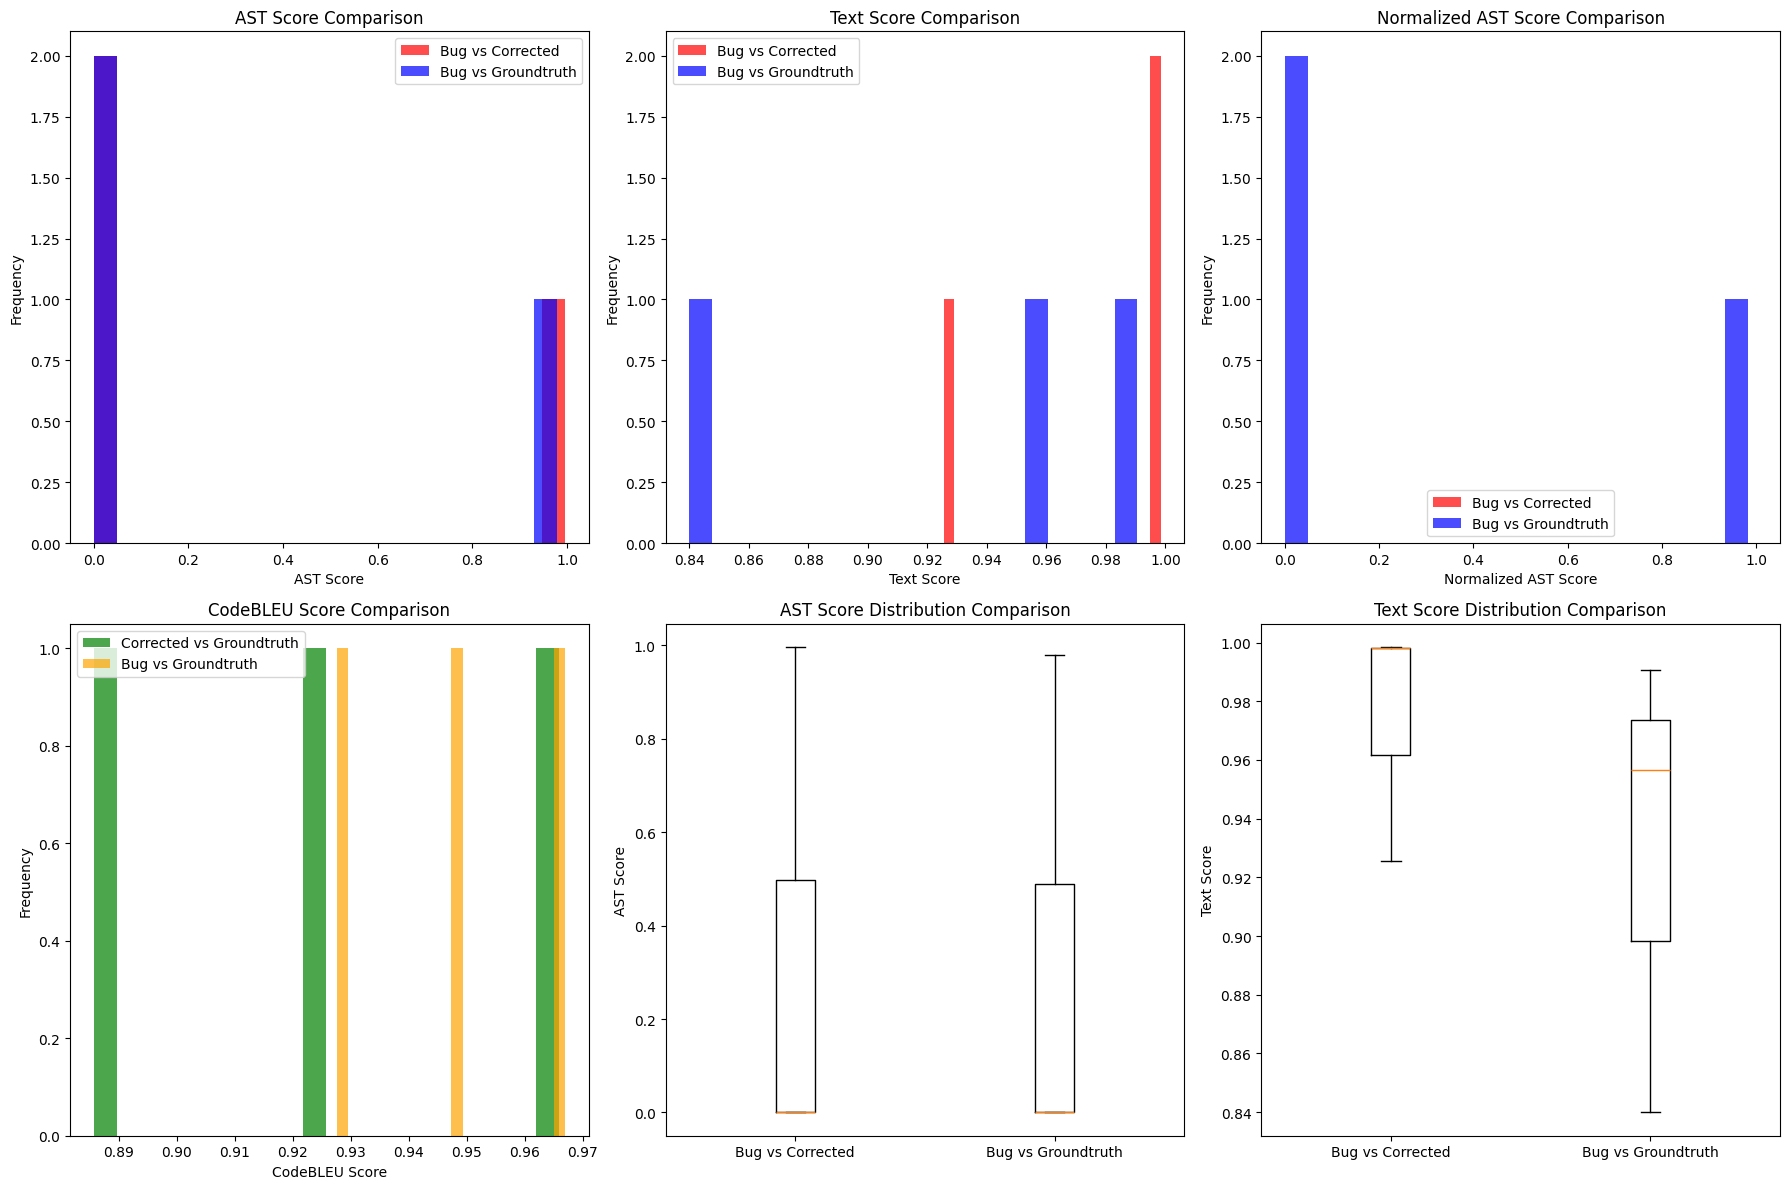

=== DIFF SCORE STATISTICS ===
AST Score - Bug vs Corrected: mean=0.332, std=0.470
AST Score - Bug vs Groundtruth: mean=0.327, std=0.462
Text Score - Bug vs Corrected: mean=0.974, std=0.034
Text Score - Bug vs Groundtruth: mean=0.929, std=0.065
Normalized AST Score - Bug vs Corrected: mean=0.998, std=0.003
Normalized AST Score - Bug vs Groundtruth: mean=0.328, std=0.463

=== CODEBLEU STATISTICS ===
CodeBLEU - Corrected vs Groundtruth: mean=0.925, std=0.033
CodeBLEU - Bug vs Groundtruth: mean=0.948, std=0.016


In [14]:
from utils.simple_metrics import diff_score, codebleu
def compare_metrics(buggy_codes, corrected_codes, groundtruth_codes):
    """Compare metrics between buggy, corrected, and groundtruth codes using histograms."""
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Calculate diff scores (returns dict with ast_score, text_score, ast_score_normalized)
    bug_vs_corrected_diff = [diff_score(bug, corr) for bug, corr in zip(buggy_codes, corrected_codes)]
    bug_vs_groundtruth_diff = [diff_score(bug, gt) for bug, gt in zip(buggy_codes, groundtruth_codes)]
    
    # Calculate codebleu scores
    corrected_vs_groundtruth_bleu = [codebleu(corr, gt) for corr, gt in zip(corrected_codes, groundtruth_codes)]
    bug_vs_groundtruth_bleu = [codebleu(bug, gt) for bug, gt in zip(buggy_codes, groundtruth_codes)]
    
    # Extract individual diff score components
    bug_vs_corrected_ast = [d['ast_score'] for d in bug_vs_corrected_diff]
    bug_vs_corrected_text = [d['text_score'] for d in bug_vs_corrected_diff]
    bug_vs_corrected_ast_norm = [d['ast_score_normalized'] for d in bug_vs_corrected_diff]
    
    bug_vs_groundtruth_ast = [d['ast_score'] for d in bug_vs_groundtruth_diff]
    bug_vs_groundtruth_text = [d['text_score'] for d in bug_vs_groundtruth_diff]
    bug_vs_groundtruth_ast_norm = [d['ast_score_normalized'] for d in bug_vs_groundtruth_diff]
    
    # Create subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Row 1: AST Score comparisons
    axes[0, 0].hist(bug_vs_corrected_ast, bins=20, alpha=0.7, label='Bug vs Corrected', color='red')
    axes[0, 0].hist(bug_vs_groundtruth_ast, bins=20, alpha=0.7, label='Bug vs Groundtruth', color='blue')
    axes[0, 0].set_xlabel('AST Score')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('AST Score Comparison')
    axes[0, 0].legend()
    
    # Row 1: Text Score comparisons
    axes[0, 1].hist(bug_vs_corrected_text, bins=20, alpha=0.7, label='Bug vs Corrected', color='red')
    axes[0, 1].hist(bug_vs_groundtruth_text, bins=20, alpha=0.7, label='Bug vs Groundtruth', color='blue')
    axes[0, 1].set_xlabel('Text Score')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('Text Score Comparison')
    axes[0, 1].legend()
    
    # Row 1: Normalized AST Score comparisons
    axes[0, 2].hist(bug_vs_corrected_ast_norm, bins=20, alpha=0.7, label='Bug vs Corrected', color='red')
    axes[0, 2].hist(bug_vs_groundtruth_ast_norm, bins=20, alpha=0.7, label='Bug vs Groundtruth', color='blue')
    axes[0, 2].set_xlabel('Normalized AST Score')
    axes[0, 2].set_ylabel('Frequency')
    axes[0, 2].set_title('Normalized AST Score Comparison')
    axes[0, 2].legend()
    
    # Row 2: CodeBLEU comparisons
    axes[1, 0].hist(corrected_vs_groundtruth_bleu, bins=20, alpha=0.7, label='Corrected vs Groundtruth', color='green')
    axes[1, 0].hist(bug_vs_groundtruth_bleu, bins=20, alpha=0.7, label='Bug vs Groundtruth', color='orange')
    axes[1, 0].set_xlabel('CodeBLEU Score')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('CodeBLEU Score Comparison')
    axes[1, 0].legend()
    
    # Row 2: Box plot for AST scores
    axes[1, 1].boxplot([bug_vs_corrected_ast, bug_vs_groundtruth_ast], 
                      labels=['Bug vs Corrected', 'Bug vs Groundtruth'])
    axes[1, 1].set_ylabel('AST Score')
    axes[1, 1].set_title('AST Score Distribution Comparison')
    
    # Row 2: Box plot for Text scores
    axes[1, 2].boxplot([bug_vs_corrected_text, bug_vs_groundtruth_text], 
                      labels=['Bug vs Corrected', 'Bug vs Groundtruth'])
    axes[1, 2].set_ylabel('Text Score')
    axes[1, 2].set_title('Text Score Distribution Comparison')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("=== DIFF SCORE STATISTICS ===")
    print(f"AST Score - Bug vs Corrected: mean={np.mean(bug_vs_corrected_ast):.3f}, std={np.std(bug_vs_corrected_ast):.3f}")
    print(f"AST Score - Bug vs Groundtruth: mean={np.mean(bug_vs_groundtruth_ast):.3f}, std={np.std(bug_vs_groundtruth_ast):.3f}")
    print(f"Text Score - Bug vs Corrected: mean={np.mean(bug_vs_corrected_text):.3f}, std={np.std(bug_vs_corrected_text):.3f}")
    print(f"Text Score - Bug vs Groundtruth: mean={np.mean(bug_vs_groundtruth_text):.3f}, std={np.std(bug_vs_groundtruth_text):.3f}")
    print(f"Normalized AST Score - Bug vs Corrected: mean={np.mean(bug_vs_corrected_ast_norm):.3f}, std={np.std(bug_vs_corrected_ast_norm):.3f}")
    print(f"Normalized AST Score - Bug vs Groundtruth: mean={np.mean(bug_vs_groundtruth_ast_norm):.3f}, std={np.std(bug_vs_groundtruth_ast_norm):.3f}")
    
    print("\n=== CODEBLEU STATISTICS ===")
    print(f"CodeBLEU - Corrected vs Groundtruth: mean={np.mean(corrected_vs_groundtruth_bleu):.3f}, std={np.std(corrected_vs_groundtruth_bleu):.3f}")
    print(f"CodeBLEU - Bug vs Groundtruth: mean={np.mean(bug_vs_groundtruth_bleu):.3f}, std={np.std(bug_vs_groundtruth_bleu):.3f}")

# Call the function with the lists
compare_metrics(sample_data['before_merge'],sample_data['after_merge'],sample_data['qwen_output'])
